In [1]:
import __init__
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
from adim import *
plt.style.use('ggplot')

Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataclasses import dataclass
import heapq

from tqdm import tqdm

def place_thresholds(dbase: EmpiricalDistribution, num_bits, transform=None):
    @dataclass
    class SubDistribution:
        d: EmpiricalDistribution

        @property
        def priority(self):
            if transform is None:
                h = self.d.entropy()
            else:
                h = self.d.transform(lambda x: jnp.searchsorted(transform, x)-1).entropy()
            return jax.scipy.special.logsumexp(dbase.log_prob(self.d.support))+jnp.log(h)

        def __lt__(self, other: "SubDistribution"):
            return self.priority > other.priority

    heap = [SubDistribution(dbase)]

    print(f"Num bits: {num_bits}")

    retired = []

    i = 0
    while i < (2**num_bits)-1:
        # take highest entropy chunk
        head = heapq.heappop(heap)
        dd = head.d

        if len(dd.support) == 1:
            retired.append(head)
            print(f"Warning: singleton chunk found with priority {head.priority}")
            # break
            continue

        i+=1

        # find the split position (should always slide off at least one value)
        if dd.probs[0] > 0.5:
            pos = (dd.support[0]+dd.support[-1])/2
        else:
            pos = dd.icdf(0.5)
            
        # split it into two halves
        _,d1,_,d2 = dd.split(pos)
        child1 = SubDistribution(d1)
        child2 = SubDistribution(d2)

        # add the two halves back to the heap
        heapq.heappush(heap, child1)
        heapq.heappush(heap, child2)

    heap.extend(retired)

    print(f"Num thresholds: {len(heap)}")
    
    thresholds_min = []
    thresholds_max = []
    for v in heap:
        thresholds_min.append(v.d.support[0])
        thresholds_max.append(v.d.support[-1])
    thresholds_min = jnp.array(sorted(thresholds_min))
    thresholds_max = jnp.array(sorted(thresholds_max))
    thresholds = (thresholds_max[:-1] + thresholds_min[1:])/2
    thresholds = jnp.concatenate([jnp.array([-jnp.inf]), thresholds, jnp.array([jnp.inf])])
    return thresholds

In [3]:

from typing import Tuple


def find_optimal(
    num_bits,
    dist: EmpiricalDistribution,
    noise_std: float = 0.0,
    method: str = "linear",
    scale_search_range: int = (2,2),
    offset_increment: float = 0.5,
    transform = None
) -> Tuple[float, jnp.ndarray]:
    """Compute the optimal bin placement for the given empirical PDF.

    Args:
        num_bits: The number of bits to use for the bin index.
        dist: The empirical distribution to quantize.
        method: Which method to use to find the optimal bin placement. Options are:
            - "uniform": Uniformly spaced bins.
            - "zoom": linearly spaced bins inside a zoomed in region.
            - "optimal": Optimal bin placement.

    Returns:
        The optimal bin placement as a Quantizer object.
    """

    if method=="uniform":
        thresholds = compute_even_levels(2**num_bits, dist.support.ptp()/2**num_bits, 0.0, offset_fixed=dist.support.mean())[0,...]
        max_MI = MI(dist, thresholds, noise_std, transform=transform)
    elif method=="zoom":
        scales =  2**jnp.arange(jnp.floor(jnp.log2(scale_search_range[0])), jnp.ceil(jnp.log2(scale_search_range[1]))+1)
        offsets = jnp.arange(
            dist.support.min(), dist.support.max(), offset_increment, dtype=jnp.float32
        )

        # find optimum by sweeping
        # print(f"num_bits: {num_bits}, offsets: {offsets}, scales: {scales}, noise_std: {noise_std}")
        MIs = sweep(dist, num_bits, offsets, scales, noise_std, transform=transform)

        # compute optimum
        max_idx = MIs.argmax()
        _, _, max_phase_idx, max_scale_idx = jnp.unravel_index(max_idx, MIs.shape)
        max_scale = scales[max_scale_idx]
        max_phase = offsets[max_phase_idx]
        max_MI = MIs[0,0, max_phase_idx, max_scale_idx]

        # recreate the optimal thresholds
        # print(f"Optimal scale: {max_scale}, phase: {max_phase}, MI: {max_MI}")
        thresholds = compute_even_levels(
            2**num_bits, max_scale, max_phase, offset_fixed=dist.support.mean()
        )[0,...]
        print(thresholds)
    elif method=="optimal":
        thresholds = place_thresholds(dist, num_bits, transform=transform)
        max_MI = MI(dist, thresholds, noise_std, transform=transform)
    else:
        raise ValueError(f"Unknown method: {method}")

    # compute the mutual information between the input and output
    return max_MI, thresholds

In [4]:
d1 = dists.Binomial(256, 0.25)
d2 = dists.Binomial(256, 0.75)
support = d1.enumerate_support()
logp1 = d1.log_prob(support)
logp2 = d2.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, 0.5*jnp.exp(logp1)+0.5*jnp.exp(logp2))

Num bits: 5
Num thresholds: 32


33

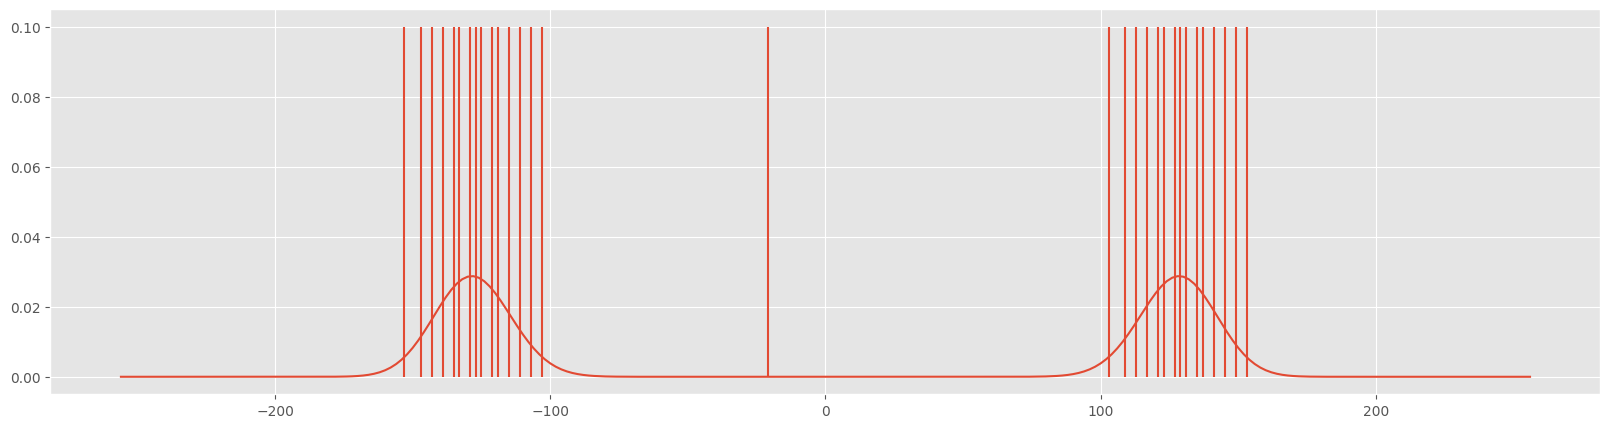

In [5]:
thresholds = place_thresholds(d, 5)

plt.figure(figsize=(20, 5))
plt.vlines(thresholds, 0.0, 0.1)
plt.plot(d.support, d.probs)
len(thresholds)

In [32]:
transform = None
d = dists.Binomial(256, 0.5)
# d = dists.BetaBinomial(0.6, 0.6, 256)
support = d.enumerate_support()
logp = d.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, jnp.exp(logp))

In [33]:
mi,theta = find_optimal(6, d, noise_std=0.1, method="optimal")
print(f"MI: {mi:.2f}, H: {d.entropy()/jnp.log(2):.2f}")

Num bits: 6
Num thresholds: 64
MI: 5.05, H: 5.05


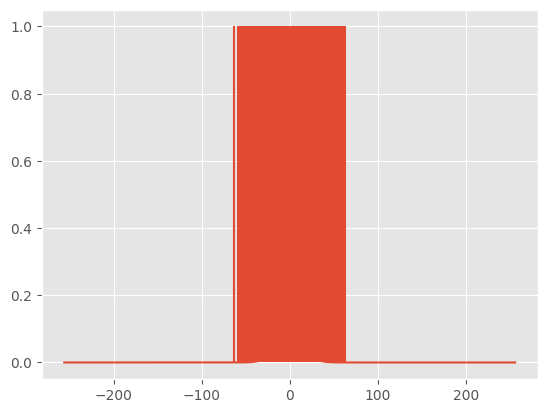

In [34]:
plt.plot(d.support, jnp.exp(d.log_prob(d.support)))
plt.vlines(theta, 0, 1)
# plt.xlim(-50,50)

In [56]:
thresholds_naive

Array([ -inf, -255., -253., -251., -249., -247., -245., -243., -241.,
       -239., -237., -235., -233., -231., -229., -227., -225., -223.,
       -221., -219., -217., -215., -213., -211., -209., -207., -205.,
       -203., -201., -199., -197., -195., -193., -191., -189., -187.,
       -185., -183., -181., -179., -177., -175., -173., -171., -169.,
       -167., -165., -163., -161., -159., -157., -155., -153., -151.,
       -149., -147., -145., -143., -141., -139., -137., -135., -133.,
       -131., -129., -127., -125., -123., -121., -119., -117., -115.,
       -113., -111., -109., -107., -105., -103., -101.,  -99.,  -97.,
        -95.,  -93.,  -91.,  -89.,  -87.,  -85.,  -83.,  -81.,  -79.,
        -77.,  -75.,  -73.,  -71.,  -69.,  -67.,  -65.,  -63.,  -61.,
        -59.,  -57.,  -55.,  -53.,  -51.,  -49.,  -47.,  -45.,  -43.,
        -41.,  -39.,  -37.,  -35.,  -33.,  -31.,  -29.,  -27.,  -25.,
        -23.,  -21.,  -19.,  -17.,  -15.,  -13.,  -11.,   -9.,   -7.,
         -5.,   -3.,

In [50]:
thresholds = theta
noise_std = 0.1
num_bits = 4
width = jnp.arange(2**(num_bits-1), d.support.ptp())
scales = width / (2**(num_bits))
phases = jnp.linspace(-20, 20, 80)
# compute MI for different scales and phases
MIs = sweep(d, num_bits, phases, scales, 0.1).squeeze(axis=(0,1))

# compute optimum
max_idx = MIs.argmax()
max_phase_idx, max_scale_idx = jnp.unravel_index(max_idx, MIs.shape)
max_scale = scales[max_scale_idx]
max_width = width[max_scale_idx]
max_phase = phases[max_phase_idx]
max_MI = MIs[max_phase_idx, max_scale_idx]

# recreate the optimal thresholds
thresholds_opt = compute_even_levels(2**num_bits, max_scale, max_phase, offset_fixed=d.support.mean())[0,...]
thresholds_naive = (jnp.arange(d.support.min(), d.support.max()+3, 2, dtype=jnp.float32)-1).at[0, ...].set(-jnp.inf).at[-1,...].set(jnp.inf)

100%|██████████| 1/1 [00:00<00:00, 281.38it/s]


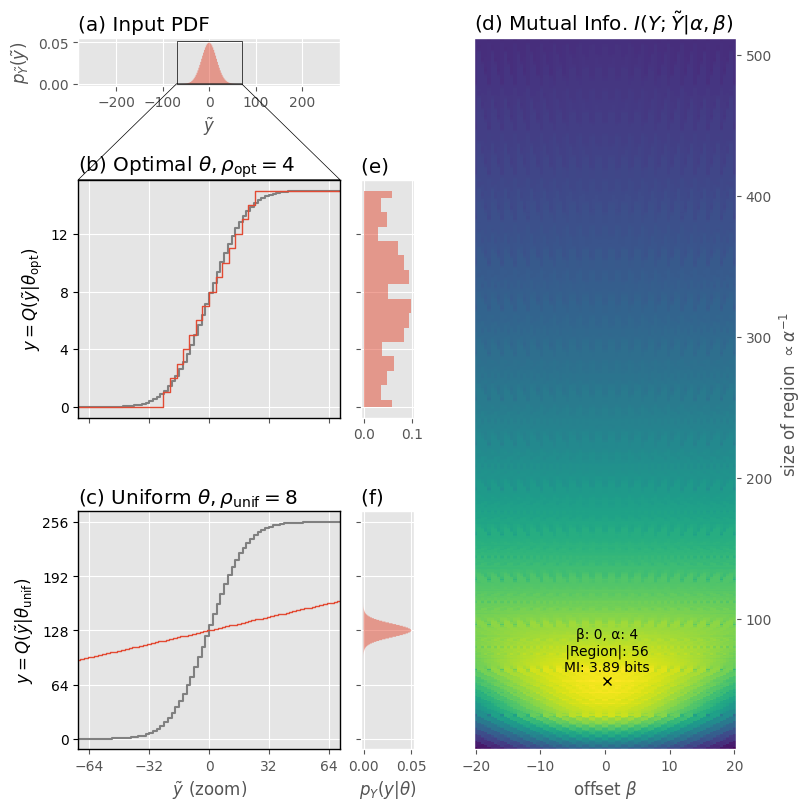

In [70]:
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnectorPatch

panels = [["a", ".", ".", "d"], ["b", "e", ".", "d"], ["c", "f", ".", "d"]]
fig, ax = plt.subplot_mosaic(
    panels,
    constrained_layout=True,
    figsize=(8, 8),
    width_ratios=[1, 0.2, 0.1, 1],
    height_ratios=[0.2, 1, 1],
    gridspec_kw={"wspace": 0.0},
)

# share axes
ax["b"].sharex(ax["c"])
# ax["e"].sharex(ax["f"])
ax["e"].sharey(ax["b"])
ax["f"].sharey(ax["c"])

# plot the input pdf
p_n = jnp.exp(d.log_prob(d.support))
ax["a"].fill_between(d.support, p_n, step="mid", alpha=0.5)

# plot the quantization functions
_, lines = plot_quantization(
    ax["b"],
    thresholds_opt,
    dist=d,
    linecolor=f"C0",
    yticklocator=MultipleLocator(2 ** (num_bits - 2)),
    xticklocator=MultipleLocator(32),
    twinaxis=False,
)
_, lines = plot_quantization(
    ax["c"],
    thresholds_naive,
    dist=d,
    linecolor=f"C0",
    yticklocator=MultipleLocator(2 ** (8 - 2)),
    xticklocator=MultipleLocator(32),
    twinaxis=False,
)

# plot the output pdfs
yy = jnp.arange(len(thresholds_opt) - 1)
P_y = jnp.exp(log_pdf_y(d, yy, thresholds_opt[jnp.newaxis, :], noise_std=noise_std))
ax["e"].fill_betweenx(yy, P_y, step="mid", alpha=0.5)

yy = jnp.arange(len(thresholds_naive) - 1)
P_y = jnp.exp(log_pdf_y(d, yy, thresholds_naive[jnp.newaxis, :], noise_std=noise_std))
ax["f"].fill_betweenx(yy, P_y, step="mid", alpha=0.5)

# plot the parameter sweep
# _, im = plot_sweep(ax["d"], phases, scales, MIs.T, annotate=(max_phase, max_scale, max_MI), cmap="viridis", rasterized=True)
im = ax["d"].pcolormesh(phases.ravel(), width.ravel(), MIs.T, cmap="viridis", rasterized=True)

# annotate optimum
ax["d"].plot(max_phase, max_width, "kx")
ax["d"].annotate(
    f"β: {max_phase:.0f}, ⍺: {max_scale:.0f}\n |Region|: {max_width} \nMI: {max_MI:.2f} bits",
    (max_phase, max_width),
    (0, 5),
    va="bottom",
    ha="center",
    textcoords="offset points",
    fontsize=10,
    # color="white",
)

# cosmetics

# set titles
title = {
    "a": "Input PDF",
    "b": "Optimal $\\theta, \\rho_\\text{opt}=4$",
    "c": "Uniform $\\theta, \\rho_\\text{unif}=8$",
    "d": "Mutual Info. $I(Y;\\tilde Y | \\alpha, \\beta)$",
    "e": "",
    "f": "",
}
for i, row in enumerate(panels):
    for j, panel in enumerate(row):
        if panel == ".":
            continue
        ax[panel].set_title(f"({panel}) {title[panel]}", loc="left")

# zoom into subregion
(xmin, xmax) = (-70, 70)
(ymin, ymax) = (0, p_n.max()*1.05)
ax["c"].set_xlim(xmin, xmax)
# add zoom effect from panel a to b
rect = Rectangle(
    (xmin, ymin),
    xmax - xmin,
    ymax - ymin,
    edgecolor="black",
    facecolor="none",
)
ax["a"].add_patch(rect)

c = BboxConnectorPatch(
    TransformedBbox(rect.get_bbox(), ax["a"].transData),
    ax["b"].bbox,
    clip_on=False,
    loc1a=3,
    loc1b=4,
    loc2a=2,
    loc2b=1,
    ec="black",
)

ax["b"].add_patch(c)
c.set_in_layout(False)

for panel in ["b", "c"]:
    ax[panel].set_frame_on(True)
    # ax_zoomed.patch.set_edgecolor("black")
    for spine in ax[panel].spines.values():
        # spine.set_edgecolor('black')
        plt.setp(spine, color="black")
    
# set labels
ax["a"].set_xlabel(r"$\tilde y$")
ax["c"].set_xlabel(r"$\tilde y$ (zoom)")
ax["f"].set_xlabel(r"$p_Y(y | \theta)$")
ax["a"].set_ylabel(r"$p_\tilde{Y}(\tilde y)$")
ax["b"].set_ylabel(r"$y=Q(\tilde y | \theta_\text{opt})$")
ax["c"].set_ylabel(r"$y=Q(\tilde y | \theta_\text{unif})$")
ax["d"].set_ylabel(r"size of region $\propto{\alpha}^{-1}$")
ax["d"].set_xlabel(r"offset $\beta$")

# flip the location of the y-axis of panel d
ax["d"].yaxis.tick_right()
ax["d"].yaxis.set_label_position("right")


# hide ticks for shared axes
plt.setp(ax["b"].get_xticklabels(), visible=False)
plt.setp(ax["e"].get_yticklabels(), visible=False)
# plt.setp(ax["e"].get_xticklabels(), visible=False)
plt.setp(ax["f"].get_yticklabels(), visible=False)

fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
fig.savefig("../figures/optimum.svg", bbox_inches="tight")
fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)

Num bits: 4
Num thresholds: 16
Num bits: 4, num thresholds: 17


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


[ -inf -225. -193. -161. -129.  -97.  -65.  -33.   -1.   31.   63.   95.
  127.  159.  191.  223.   inf]
Num bits: 4, num thresholds: 17
Num bits: 4, num thresholds: 17


Text(13.041999999999996, 0.5, '$p_Y(y|\\theta)$')

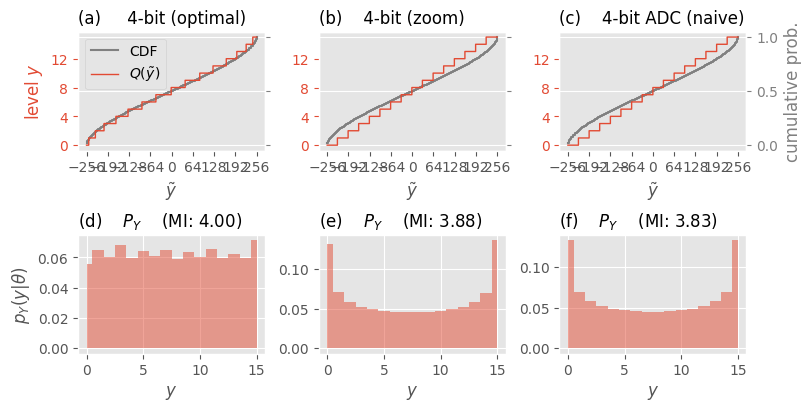

In [10]:

# create the figure
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
# share_axis(ax[:,:-1], sharex="row", sharey="row")

vector_length = 256
self = dists.Binomial(vector_length, 0.5)
support = jnp.array(self.enumerate_support())*2 - vector_length
probabilities = jnp.exp(self.log_prob(self.enumerate_support()))

phase = jnp.linspace(-vector_length, vector_length, 1000)
scale = jnp.logspace(-1, 2, 1000)
noise_std=0.1

vmin, vmax = 0, jnp.log2(4*jnp.pi*jnp.e)
all_thresholds = []

cases = [("(a)     4-bit (optimal)", "(d)    $P_Y$", 4, "optimal"),("(b)    4-bit (zoom)", "(e)    $P_Y$", 4, "zoom"),("(c)    4-bit ADC (naive)", "(f)    $P_Y$", 4, "uniform")]
for i,(label1, label2, bits, method) in enumerate(cases):
    # compute MI for different scales and phases
    mi, thresholds = find_optimal(bits, d, noise_std=noise_std, method=method, transform=transform, scale_search_range=(0.1, 20))
    all_thresholds.append(thresholds)
    print(f"Num bits: {bits}, num thresholds: {len(thresholds)}")

    ax_cdf, ax_fun, lines = plot_quantization(ax[0,i], thresholds, dist=d, color=f"C0", yticklocator=MultipleLocator(2**(bits-2)))
    # ax_sweep, im = plot_sweep(ax[1,i], phase, scale, MIs, annotate=(max_phase, max_scale, max_MI), vmin=vmin, vmax=vmax, cmap="viridis", rasterized=True)
    
    if i != 0:
        ax_fun.yaxis.label.set_visible(False)

    if i == 2:
        ax_cdf.yaxis.label.set_visible(True)
        ax_cdf.set_yticks([0,0.5,1.0])
    else:
        ax_cdf.yaxis.label.set_visible(False)
        plt.setp(ax_cdf.get_yticklabels(), visible=False)

    # im = plot_sweep()

    labels = [l.get_label() for l in lines]

    ax_fun.set_ylabel("level $y$")
    ax_fun.set_xlabel("$\\tilde{y}$")
    # ax_fun.set_xlim(-80,80)
    ax_fun.set_title(label1, fontsize=12, loc="left")
    # ax_sweep.set_title(label2, fontsize=12, loc="left")
    # ax_sweep.set_xlabel("offset")
    if i == 0:
        ax_fun.legend(handles=lines, labels=labels, loc="upper left", fancybox=True, ncol=1)

    

    yy = jnp.arange(len(thresholds)-1)
    P_y = jnp.exp(log_pdf_y(d, yy, thresholds[jnp.newaxis,:], noise_std=noise_std))
    ax[1,i].fill_between(yy, P_y, step="mid", alpha=0.5)

    ax[1,i].set_title(label2 + f"    (MI: {mi:.2f})", fontsize=12, loc="left")
    ax[1,i].set_xlabel("$y$")

# fig.colorbar(im, ax=ax[1,:], label="MI (bits)", pad=-0.075)
# place legend in axis, hide everything else
# ax[0,-1].axis("off")

ax[1, 0].set_ylabel("$p_Y(y|\\theta)$")

# fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
# fig.savefig("../figures/optimum.svg", bbox_inches="tight")
# fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)

In [30]:
num_bits = 6
transform = jnp.arange(-3, 2**num_bits+3, 2.0).at[0].set(-jnp.inf).at[-1].set(jnp.inf)

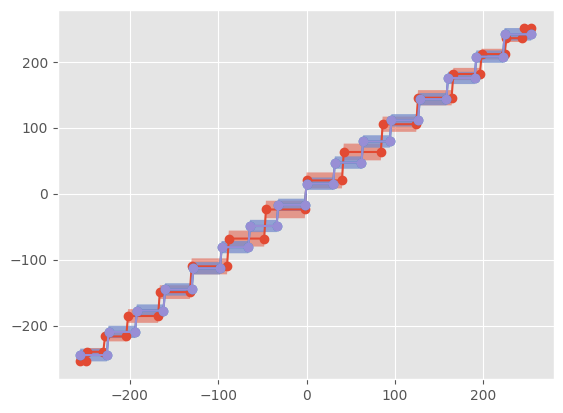

In [11]:
for thresholds in all_thresholds:
    m = []
    s = []
    tc = []
    dtemp = EmpiricalDistribution(d.support, log_probs=d.log_probs)
    for i, t in enumerate(thresholds[1:]):
        _, d1, _, d2 = dtemp.split(t)
        dtemp = d2
        if transform is not None:
            d1_trans = d1.transform(lambda x: jnp.searchsorted(transform, x)-1)
        else:
            d1_trans = d1
        if len(d1.support) == 0:
            continue
        m.append(d1_trans.mean)
        s.append(d1_trans.std)
        m.append(d1_trans.mean)
        s.append(d1_trans.std)
        tc.append(d1.support.min())
        tc.append(d1.support.max())
    m=jnp.array(m)
    s=jnp.array(s)
    tc=jnp.array(tc)

    
    plt.fill_between(tc, m+s, m-s, alpha=0.5)
    plt.plot(tc, m, "-o")
# plt.xlim(-10,100)
# plt.ylim(-10,40)

In [13]:
class StepFunction(object):
    thresholds: jnp.ndarray
    values: jnp.ndarray

    def __init__(self, thresholds, values=None):
        if values is None:
            values = jnp.arange(len(thresholds)-1)
        assert len(thresholds) == len(values)+1, "Thresholds must be one longer than values"
        self.thresholds = thresholds.at[0].set(-jnp.inf).at[-1].set(jnp.inf)
        self.values = values

    def __call__(self, x):
        idx = jnp.searchsorted(self.thresholds, x)-1
        return self.values[idx]

TypeError: 'jaxlib.xla_extension.ArrayImpl' object is not callable

In [56]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

def plot_quantization(
    ax_fun,
    thresholds,
    dist=None,
    color=None,
    linecolor=None,
    xticklocator=MultipleLocator(64),
    yticklocator=MaxNLocator(integer=True),
    remove_endpoints=True,
    xmin=None,
    xmax=None,
    step=True,
    twinaxis=True,
):
    if linecolor is None:
        linecolor = color

    if remove_endpoints:
        thresholds = thresholds[1:-1]

    if xmin is None:
        if dist is not None:
            xmin = dist.support.min()
        else:
            xmin = thresholds.min()
    if xmax is None:
        if dist is not None:
            xmax = dist.support.max()
        else:
            xmax = thresholds.max()

    num_levels = len(thresholds) + 1

    xx = jnp.linspace(xmin, xmax, 1001)

    if dist is not None:
        nn = dist.support
        n_cdf = dist.cdf(nn)

        if twinaxis:
            # callback for when the ylim of ax_cdf is changed
            def update_cdf_ylim(ax_fun):
                y1, y2 = ax_fun.get_ylim()
                ax_cdf.set_ylim(y1 / (num_levels - 1), y2 / (num_levels - 1))
                ax_cdf.figure.canvas.draw()

            # create twin axis for the CDF
            ax_cdf = ax_fun.twinx()
            # swap zorder so that the CDF is behind the quantization levels
            ax_fun.set_zorder(ax_cdf.get_zorder() + 1)

            # automatically update ylim of ax2 when ylim of ax1 changes.
            ax_fun.callbacks.connect("ylim_changed", update_cdf_ylim)

            ax_cdf.yaxis.label.set_color("gray")
            ax_cdf.tick_params(axis="y", colors="gray")
            ax_cdf.grid(True, zorder=0)
            ax_cdf.xaxis.grid(True, zorder=0)
            ax_fun.grid(False)
            ax_cdf.set_ylabel("cumulative prob.")
            # Set ax's patch invisible
            ax_fun.patch.set_visible(False)
            # Set axtwin's patch visible and colorize it in grey
            ax_cdf.patch.set_visible(True)
            ax_cdf.patch.set_facecolor(ax_fun.patch.get_facecolor())
            scale = 1
        else:
            ax_cdf = ax_fun
            scale = num_levels - 1

        if step:
            l1 = ax_cdf.step(nn, n_cdf * scale, color="gray", where="post", label="CDF")
        else:
            nn_mid = (nn[1:] + nn[:-1]) / 2
            n_cdf_mid = (n_cdf[1:] + n_cdf[:-1]) / 2
            l1 = ax_cdf.plot(nn_mid, n_cdf_mid * scale, color="gray", label="CDF")
    else:
        l1 = []

    l2 = ax_fun.step(
        xx,
        jnp.searchsorted(thresholds, xx),
        color=linecolor,
        linewidth=1,
        label="$Q(\\tilde y)$",
    )

    if color is not None:
        ax_fun.yaxis.label.set_color(color)
        ax_fun.tick_params(axis="y", colors=color)
    ax_fun.set_ylabel("level")

    ax_fun.xaxis.set_major_locator(xticklocator)
    ax_fun.yaxis.set_major_locator(yticklocator)
    ax_fun.set_xlim(xmin - (xmax - xmin) * 0.05, xmax + (xmax - xmin) * 0.05)

    if twinaxis:
        return ax_cdf, ax_fun, l1 + l2
    else:
        return ax_fun, l1 + l2